# Baseline
---

В данном ноутбуке находится предоставленный Моторикой baseline работы с данными из ОМГ-датчиков. Код в ячейках оставлен большею частью в исходном виде (включая порядок импорта библиотек, модулей и классов). Добавлены комментарии к коду.

---

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

## IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

## Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC — encoders (fingers of prosthesis or gloves)  
model — model of data  

## Data

Для демонстрации baseline-решения авторы выбрали один из сетов (один из лучших) второго пилота.

In [3]:
palm_file = './data/data_from_4_pilots/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(19568, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909


Подгруженные данные из palm-файла они снабдили подробным комментарием:

In [4]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

Далее для быстрого обращения к колонкам массива они создали соответствующие списки наименований.

In [5]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


Предпросмотр динамики сигналов датчиков.

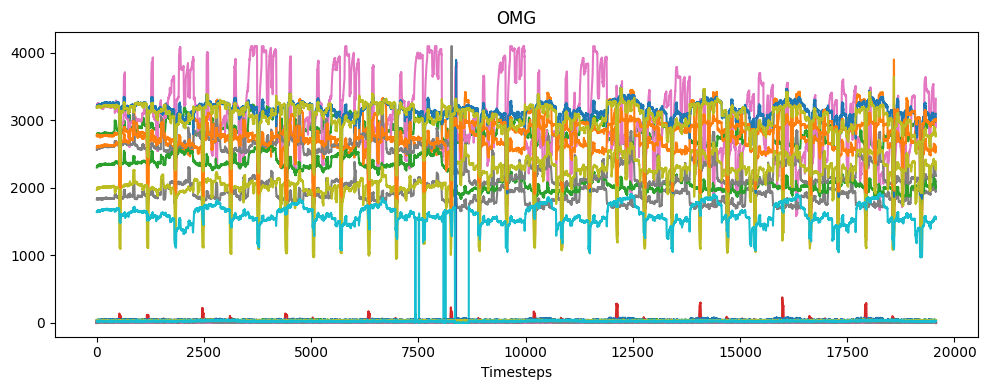

In [6]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

В этом разделе осуществляется чтение файла протокола, идущего в пару к каждому сету с данными наблюдения. Именно здесь происходит извлечение вектора таргета.

In [7]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
176,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
177,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
178,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


Как было пояснено выше в комментариях, SYNC отвечает за синхронизацию данных с протоколом.

In [8]:
gestures['SYNC'].value_counts()

0      11266
57        58
67        58
97        47
135       47
       ...  
52        46
1         45
103       45
104       45
12        39
Name: SYNC, Length: 181, dtype: int64

Как видим, число классов совпадает с числом эпох в протоколе. Далее идет этап перекодировки классов таргета.

In [9]:
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

Формируется список имен жестов.

In [10]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [11]:
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int32

Вектор целевого признака собирается из столбца SYNC, значения которого заменяются на номер класса жеста, исполняемого в каждую эпоху, из столбца gesture в протоколе.

In [12]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

Совместный вывод общей панорамы данных и тергета.

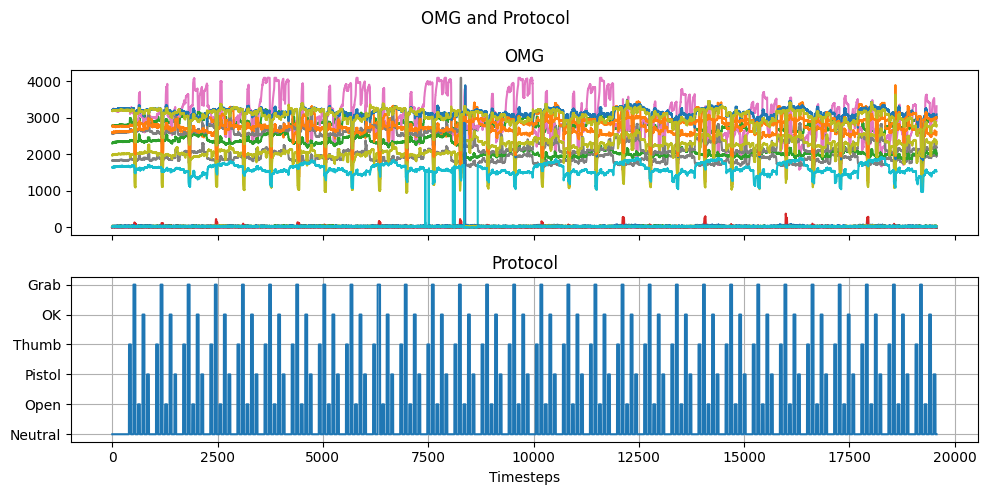

In [13]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

## Train-test split

Сплитование на выборки происходит согласно отмеченному в таблице метаданных последнему индексу треннировочной выборки. В данной задаче класическое сплитование на 0.8/0.2 нецелесообразно, т.к. в таком случае велик риск нарушить равное представительство классов жестов в обеих выборках.

In [14]:
df_meta = pd.read_csv('./data/data_from_4_pilots/meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [15]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

In [16]:
X_train = gestures[OMG_CH].values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = gestures[OMG_CH].values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 50) (15679,)
(3889, 50) (3889,)


## Modeling

В baseline тестировался алгоритм логистической регрессии с дефолтными параметрами. Однако из-за предупреждений о нехватке числа итераций для схождения был подобран оптимизатор liblinear.

Импорт класса оригинальный.

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    solver='liblinear'
)

model.fit(
    X=X_train,
    y=y_train
)

LogisticRegression(solver='liblinear')

Авторы визуализировали коэффициенты модели.

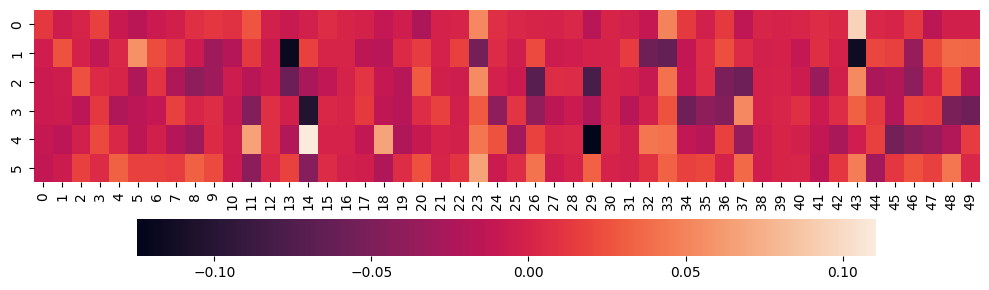

In [18]:
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
plt.tight_layout()

## Prediction

Предсказание жестов по данным вынесено в отдельный раздел.

In [21]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

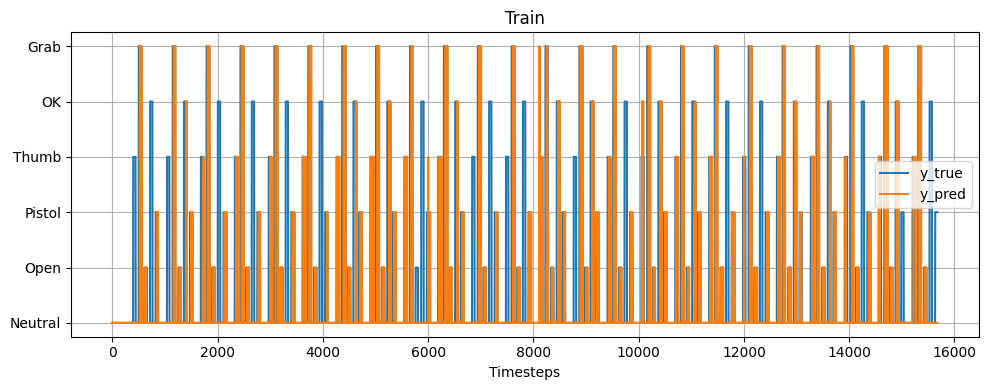

In [22]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

Как можно видеть уже на предсказаниях в трейне, качество модели оставляет желать лучшего.

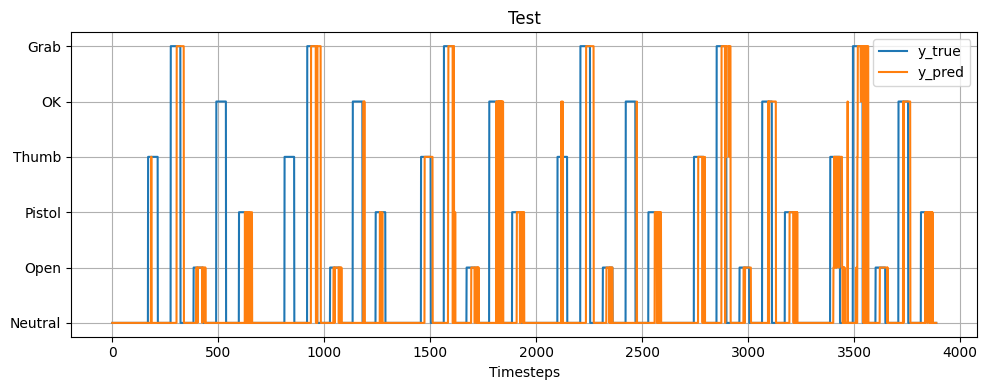

In [23]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

Результат в тесте предсказуемо плохой. Однако стоит отметить корреляцию предсказаний с таргетом, хоть они и чуть сдвинуты вправо и загрязнены шумами.

## Metrics

In [24]:
from sklearn.metrics import classification_report

print(classification_report(
    y_train, y_pred_train, target_names=GESTURES, digits=4
))

print(classification_report(
    y_test, y_pred_test, target_names=GESTURES, digits=4
))

              precision    recall  f1-score   support

     Neutral     0.7154    0.9367    0.8112     10151
        Open     0.8411    0.4891    0.6186      1104
      Pistol     0.7234    0.3097    0.4337      1098
       Thumb     0.6429    0.2527    0.3628      1104
          OK     0.2846    0.0317    0.0570      1104
        Grab     0.7135    0.4589    0.5585      1118

    accuracy                         0.7153     15679
   macro avg     0.6535    0.4131    0.4736     15679
weighted avg     0.6892    0.7153    0.6685     15679

              precision    recall  f1-score   support

     Neutral     0.7235    0.9067    0.8048      2508
        Open     0.7442    0.5797    0.6517       276
      Pistol     0.7097    0.3188    0.4400       276
       Thumb     0.7290    0.2826    0.4073       276
          OK     0.4362    0.1486    0.2216       276
        Grab     0.5971    0.4440    0.5093       277

    accuracy                         0.7107      3889
   macro avg     0.6566

Удивительно, но метрики на тесте даже чуть выше, чем в трейне.

## Real-time inference

Это раздел, где происходит инференс модели. В исходном ноутбуке с baseline-решением присутствовал также подраздел с онлайн-инференсом, использовать который предполагалось уже в офисе Моторики совместно со специалистами компании. Отличие от офлайн-инференса состоит только в настройках подключения к серверу, осуществляющему доступ к микроконтроллеру протеза. В данном варианте ноутбука этот раздел исключен за ненадобностью.

In [19]:
import time
# import serial
# from IPython.display import clear_output

### Inference Utils: Put your code here

В этом подразделе должна вестись работа над функциями, обеспечивающими процесс итеративной обработки вновь поступающих данных на инференс.

In [25]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

### Inference

#### Offline (dataset)

Инференс проходит на тестовой выборке.

In [26]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


В переменной TIMEOUT обозначен предел по времени на итерацию: если модель и код обработки превысят лимит, сработает соответствующий assert.

In [27]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [28]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 50)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


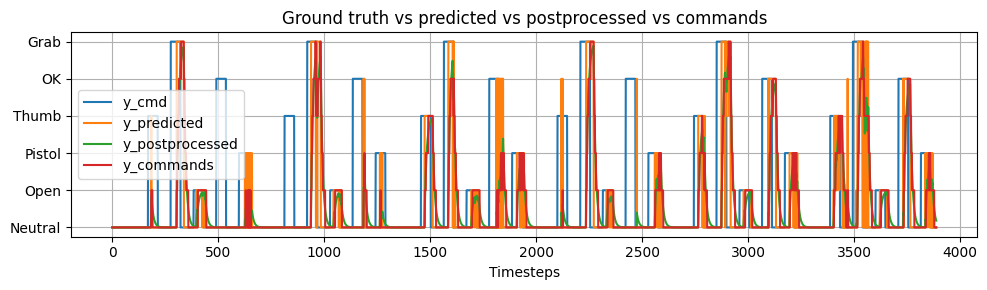

In [29]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

На инференсе в частности проверяется чистота и точность сформированных команд на основе предсказаний: здесь изучается возможность использования модели для управления работой протеза.

In [30]:
print(classification_report(
    y_test, y_dct['y_commands'], target_names=GESTURES, digits=4
))

              precision    recall  f1-score   support

     Neutral     0.6837    0.7731    0.7257      2508
        Open     0.2344    0.4638    0.3114       276
      Pistol     0.1257    0.0833    0.1002       276
       Thumb     0.1268    0.0652    0.0861       276
          OK     0.0211    0.0109    0.0144       276
        Grab     0.0500    0.0072    0.0126       277

    accuracy                         0.5433      3889
   macro avg     0.2070    0.2339    0.2084      3889
weighted avg     0.4805    0.5433    0.5052      3889



Да, результат *стал* хуже. Однако мы можем вернуть предыдущий результат, если отправим в функцию `classification_report` вектор данных `y_dct['y_predicted']`.

Все дело в том, что предсказания настолько плохие, что используемые в бейзлайне функции постобработки приводят к выводу команд на исполнение совсем иных жестов, нежели в протоколе.

## Вывод

В данном ноутбуке был рассмотрен baseline от Моторики, задающий общий план работы с данными.

Т.о., перед нами здесь поставлен ряд нетривиальных задач, в ходе поиска решений для которых нами должен быть предусмотрен также способ объединения данных разных пилотов для обучения генеральных моделей.